# **Auswertung der Energieverbrauchsmessung**
___

In [17]:
#fuer graphische Darstellung
%matplotlib inline

#automatische Aktualisierung von Bibliotheken
%load_ext autoreload    
%autoreload 2

import datetime as dt
import os               #Pfade
import locale           #Spracheinstellung: Deutsch (DE)
locale.setlocale(locale.LC_ALL,'de_DE')

import numpy as np      #Datenmanagement Bibliothek (matritx operationen)
import pandas as pd     #Datenmanagement Bibliothek (wie excel)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use(".\src\stylesheets\eb3.mplstyle")     #Style-Vorlagendatei (z.B. Grids, Achsen, Schriftgroeße, etc.)

#eigene Bibliotheken (importiert aus src)
from src.project_definitions import BUID, AREA, WOHNUNGEN, ROOMS, dir_results, area
from src.utilities import recolor_lines, export, truncate_colormap, DIN, INDOC, eb_bbox
from src.update_databases import up
from src.sensor_reader import import_data

### update databases ###
up()

### import databases ###
IND, AMB, EM = import_data()

### export results? True = Export Graphiken für alle Räume + Bauweisen (dauert!) / False = macht nur eine definierte Variante ###
ex  = True

### result path ###
exdir = os.path.join(dir_results,'Energiebedarf')
if not os.path.isdir(exdir):
    os.makedirs(exdir)

29.03.2022 11:50:58 -- INFO -- ------ Starte TinkerForge Update------
29.03.2022 11:50:58 -- INFO -- MH: Suche vorhandene Datenbank.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


29.03.2022 11:51:15 -- INFO -- MH: Datenbank geöffnet, letzter Eintrag vom 2022-03-28!
29.03.2022 11:51:15 -- INFO -- MH: Durchsuche Dropbox nach neuen Datensätzen.


29.03.2022 11:51:19 -- INFO -- MH: TinkerForge Datenbanken up to date! | 2021-02-08 11:00:51 | 2022-03-28 23:07:57
29.03.2022 11:51:19 -- INFO -- MW: Suche vorhandene Datenbank.
29.03.2022 11:51:33 -- INFO -- MW: Datenbank geöffnet, letzter Eintrag vom 2022-03-28!
29.03.2022 11:51:33 -- INFO -- MW: Durchsuche Dropbox nach neuen Datensätzen.


29.03.2022 11:51:37 -- INFO -- MW: TinkerForge Datenbanken up to date! | 2021-02-23 17:19:00 | 2022-03-28 23:07:20
29.03.2022 11:51:37 -- INFO -- LB: Suche vorhandene Datenbank.
29.03.2022 11:51:51 -- INFO -- LB: Datenbank geöffnet, letzter Eintrag vom 2022-03-28!
29.03.2022 11:51:51 -- INFO -- LB: Durchsuche Dropbox nach neuen Datensätzen.


29.03.2022 11:51:55 -- INFO -- LB: TinkerForge Datenbanken up to date! | 2021-03-08 11:15:55 | 2022-03-28 23:08:47
29.03.2022 11:51:55 -- INFO -- PM: Suche vorhandene Datenbank.
29.03.2022 11:51:57 -- INFO -- PM: Datenbank geöffnet, letzter Eintrag vom 2022-03-28!
29.03.2022 11:51:57 -- INFO -- PM: Durchsuche Dropbox nach neuen Datensätzen.


29.03.2022 11:52:02 -- INFO -- PM: TinkerForge Datenbanken up to date! | 2021-03-08 11:15:55 | 2022-03-28 23:08:47
29.03.2022 11:52:02 -- INFO -- WD: Suche vorhandene Datenbank.
29.03.2022 11:52:04 -- INFO -- WD: Datenbank geöffnet, letzter Eintrag vom 2022-03-28!
29.03.2022 11:52:04 -- INFO -- WD: Durchsuche Dropbox nach neuen Datensätzen.


29.03.2022 11:52:08 -- INFO -- WD: TinkerForge Datenbanken up to date! | 2021-03-08 11:18:55 | 2022-03-28 23:08:47
29.03.2022 11:52:08 -- INFO -- ------TinkerForge Update beendet!------
29.03.2022 11:52:08 -- INFO -- Molline-Datenbank up-to-date. Kein Update notwendig.


# **Energieverbrauch**

## **WÄRME**

### **Wärmeenergie (total)**


gesamter Zeitraum
____

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Wärmeenergieverbrauch.pdf saved!


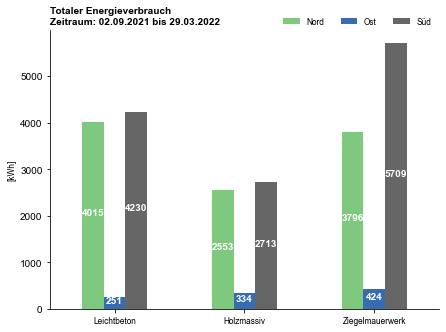

In [18]:
idx = pd.IndexSlice
df = EM.loc(axis=1)[idx[:, ["N", "O", 'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.resample('365d').last() - df.resample('365d').first()
df.reset_index(drop=True).round(2)
fig,ax = plt.subplots(figsize=INDOC)
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Totaler Energieverbrauch\nZeitraum: {(EM.index.min().strftime("%d.%m.%Y"))} bis {EM.index.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch',extlist=['pdf'], show=True)

### **Wärmeenergie (spezifisch)**


Winter
____

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Wärmeenergieverbrauch_spezifisch_Winter.pdf saved!


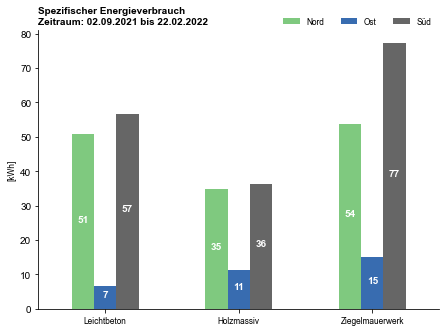

In [19]:
idx = pd.IndexSlice
startdate = dt.datetime(2021,9,2)
enddate = dt.datetime(2022,2,22)
df = EM.loc(axis=1)[idx[:, ["N", "O", 'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.loc[startdate:enddate]
df = df.resample('5000d').last() - df.resample('5000d').first()
df = df.reset_index(drop=True).div(AREA,level=1).round(2)
fig,ax = plt.subplots(figsize=INDOC)
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Spezifischer Energieverbrauch\nZeitraum: {(startdate.strftime("%d.%m.%Y"))} bis {enddate.strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch_spezifisch_Winter',extlist=['pdf'], show=True)

gesamter Zeitraum
___

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\spezifischer_Wärmeenergieverbrauch.pdf saved!


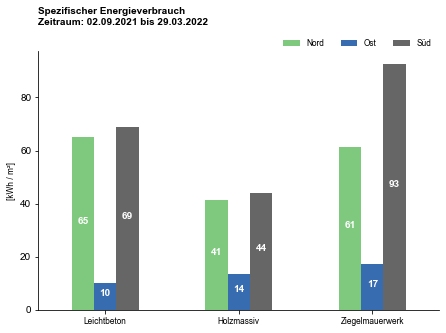

In [20]:
idx = pd.IndexSlice
df = EM.loc(axis=1)[idx[:, ["N", "O",'S'],'HQ','H']].droplevel([2,3],axis=1)
df = df.resample('365d').last() - df.resample('365d').first()
df = df.reset_index(drop=True).div(AREA,level=1).round(2)
fig,ax = plt.subplots(figsize=INDOC)
df.stack().T.droplevel(0,axis=1).plot.bar(ax=ax,cmap = 'Accent')
ax.set_title(f'Spezifischer Energieverbrauch\nZeitraum: {(EM.index.min().strftime("%d.%m.%Y"))} bis {EM.index.max().strftime("%d.%m.%Y")}', fontweight = 'bold', y=1.08)
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{bar.get_height():.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,'spezifischer_Wärmeenergieverbrauch',extlist=['pdf'], show=True)

### **Wärmeenergie (kumuliert)**

gesamter Zeitraum
____

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Wärmeenergieverbrauch_kumuliert.pdf saved!


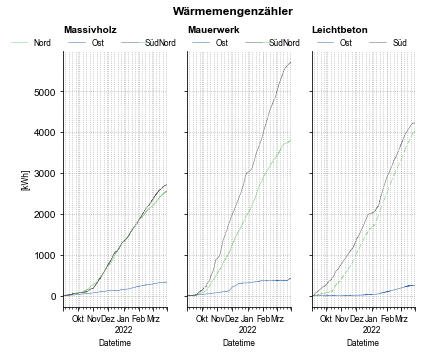

In [21]:
fig, axs = plt.subplots(1,3,sharex=True, sharey=True,figsize=INDOC)
fig.suptitle(f'Wärmemengenzähler',y=1.01)
for b, bui in enumerate(BUID):
    df = EM.loc(axis=1)[idx[bui,['N','O','S'],'HQ','H']].droplevel([0,2,3],axis=1).resample('H').last()
    (df - df.min()).plot(ax=axs[b], cmap = 'Accent')
    axs[b].legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
    axs[b].set_title(f'{BUID[bui]}',y=1.05)
axs[0].set_ylabel(f'[kWh]')
if ex:
    export(fig,exdir,'Wärmeenergieverbrauch_kumuliert',extlist=['pdf'], show=True)

## **STROM**

### Stromverbrauch (spezifisch)

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Stromverbrauch_spezifisch_normalisiert.pdf saved!


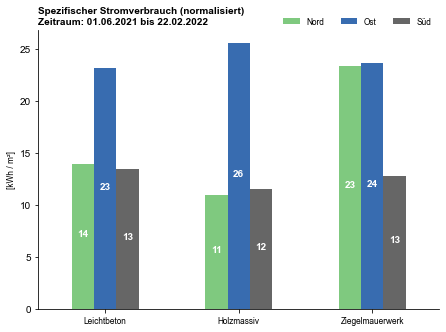

In [22]:
Normalize = True

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,6,1)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

df = df.reset_index(drop=True).div(AREA,level=1).round(2)


df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=INDOC)
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    title = 'Spezifischer Stromverbrauch (normalisiert)'
    fname = 'normalisiert'
    ax.set_title(f'{title}\nZeitraum: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    title = 'Spezifischer Stromverbrauch (absolut)'
    fname = 'absolut'
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,f'Stromverbrauch_spezifisch_{fname}',extlist=['pdf'], show=True)

### Stromverbrauch (gesamt)

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Stromverbrauch_total_normalisiert.pdf saved!


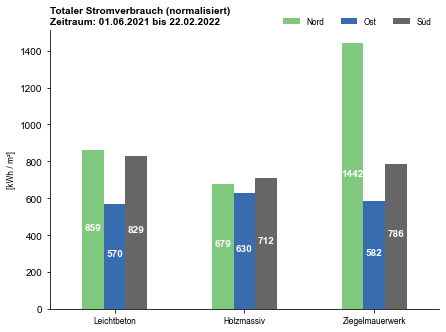

In [23]:
Normalize = True

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,6,1)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=INDOC)
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    title = 'Totaler Stromverbrauch (normalisiert)'
    fname = 'normalisiert'
    ax.set_title(f'{title}\nZeitraum: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    title = 'Totaler Stromverbrauch (absolut)'
    fname = 'absolut'
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,f'Stromverbrauch_total_{fname}',extlist=['pdf'], show=True)

### Stromverbrauch (Winter)

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Stromverbrauch_total_Winter.pdf saved!


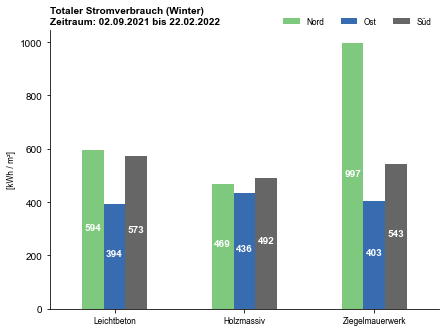

In [24]:
Normalize = True

Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    start = dt.datetime(2021,9,2)
    sollT = dt.date.today()-start.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    date = group.index
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T
    date = Stromverbrauch.index

df = df.stack().T.droplevel(0,axis=1)

fig,ax = plt.subplots(figsize=INDOC)
df.plot.bar(ax=ax,cmap = 'Accent')

if Normalize:
    title = 'Totaler Stromverbrauch (Winter)'
    fname = 'Winter'
    ax.set_title(f'{title}\nZeitraum: {start.strftime("%d.%m.%Y")} bis {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
else:
    title = 'Totaler Stromverbrauch (absolut)'
    fname = 'absolut'
    ax.set_title(f'{title}\nletztes Ablesedatum: {date.max().strftime("%d.%m.%Y")}', fontweight = 'bold')
ax.set_ylabel('[kWh / m²]')
ax.set_xticklabels(['Leichtbeton', 'Holzmassiv', 'Ziegelmauerwerk'], rotation=0)
ax.grid(False)
ax.legend(labels=['Nord','Ost','Süd'],loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
xticks=[]
for bar in ax.patches:
    xticks.append(bar.get_x())

    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        color='w',
        weight='bold',
        )

fig.tight_layout()
if ex:
    export(fig,exdir,f'Stromverbrauch_total_{fname}',extlist=['pdf'], show=True)

In [39]:
Stromverbrauch

,MH,MW,LB,MH,MW,LB,MH,MW,LB
Datetime,N,N,N,O,O,O,S,S,S
2020-07-01,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0
2020-10-01,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2021-04-01,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
2022-02-22,670.0,1567.0,1716.0,1066.0,985.0,1138.0,629.0,935.0,1656.0


In [25]:
plt.style.use('./src/stylesheets/eb3_präsi.mplstyle')

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Spez.Energieverbrauch_App.png saved!


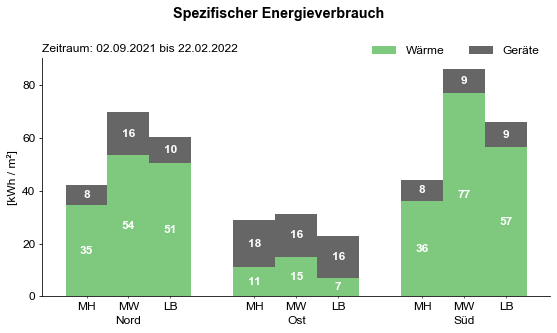

In [37]:
Normalize = True

idx = pd.IndexSlice

startdate = dt.datetime(2021,9,2)
enddate = dt.datetime(2022,2,22)

df1 = EM.loc(axis=1)[idx[:, ["N", "O", 'S'],'HQ','H']].droplevel([2,3],axis=1)
df1 = df1.loc[startdate:enddate]
df1 = df1.resample('5000d').last() - df1.resample('5000d').first()
df1 = df1.reset_index(drop=True).div(AREA,level=1).round(2)
df1 = df1.stack().T.droplevel(0,axis=1)
Stromverbrauch = pd.read_csv('.\src\Stromzähler.csv', header=[0,1], index_col=[0], sep=';')
Stromverbrauch.index = pd.to_datetime(Stromverbrauch.index,format='%d.%m.%Y')
if Normalize:
    sollT = dt.date.today() - startdate.date()
    dfs=[]
    idx=[]
    for name, group in Stromverbrauch.groupby(level=[0,1],axis=1):
        group = group.dropna()
        deltaT = group.index.max()-group.index.min()
        df = (group.max() / deltaT.days) * sollT.days
        cols = df.index
        idx.extend(cols)
        dfs.append(df.values)
    idx = pd.MultiIndex.from_tuples(idx)
    df = pd.DataFrame(dfs, index=idx, columns=[group.index.max()]).T
else:
    df = pd.DataFrame(Stromverbrauch.loc[Stromverbrauch.index.max(),:]).T

df = df.reset_index(drop=True).div(AREA,level=1).round(2)


df = df.stack().T.droplevel(0,axis=1)
df = pd.concat([df1.unstack(), df.unstack()], axis=1, keys=['Wärme','Strom'])

fig, ax = plt.subplots()
xticks = []
xlabels = []
xmajor = []
for i, app in enumerate(df.index.get_level_values(0).unique()):
    xmajor.append(WOHNUNGEN[app])
    for j, bui in zip([-0.25,0,0.25], BUID):
        w1, = ax.bar(i+j, df.loc[(app, bui)]['Wärme'], width=0.25, color=mpl.cm.Accent(0))
        w2, = ax.bar(i+j, df.loc[(app, bui)]['Strom'], width=0.25, bottom=df.loc[(app, bui)]['Wärme'], color=mpl.cm.Accent(100))
        xticks.append(i+j)
        xlabels.append(bui)

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        va='center',
        color='w',
        weight='bold',
        )
        
ax.set_xticks(xticks, minor=True)
ax.set_xticklabels(xlabels, minor=True)
ax.xaxis.remove_overlapping_locs = False
ax.set_xticks([0,1,2], minor=False)
ax.set_xticklabels(xmajor, minor=False)
ax.tick_params(axis='x', which='major', length=16, width=0)

ax.grid(False, which='both')
ax.legend(handles=[w1, w2], labels = ['Wärme', 'Geräte'], loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
fig.suptitle(f'Spezifischer Energieverbrauch')
ax.set_title(f'Zeitraum: {startdate.strftime("%d.%m.%Y")} bis {enddate.strftime("%d.%m.%Y")}', fontweight = 'normal', fontsize = "medium")
ax.set_ylabel('[kWh / m²]', fontsize = "medium")
fig.tight_layout()

if ex:
    export(fig,exdir,f'Spez.Energieverbrauch_App',extlist=['png'], show=True)

\\nas.ads.mwn.de\tuar\l15\private\DATA\FORSCHUNG\04_Projekte\2021\Einfach_Bauen_3\Daten\3_auswertung\Energiebedarf\Spez.Energieverbrauch_Bui.png saved!


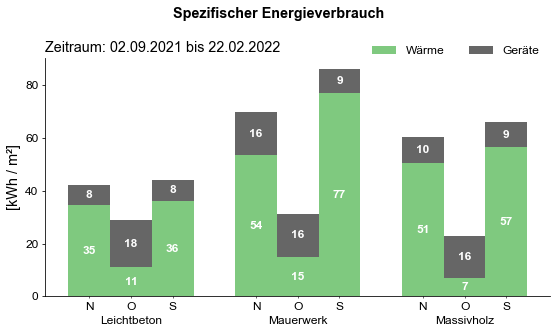

In [36]:
fig, ax = plt.subplots()
xticks = []
xlabels = []
xmajor = []
for i, app in zip([-0.25,0,0.25], df.index.get_level_values(0).unique()):
    
    for j, bui in enumerate(BUID):
        w1, = ax.bar(i+j, df.loc[(app, bui)]['Wärme'], width=0.25, color=mpl.cm.Accent(0))
        w2, = ax.bar(i+j, df.loc[(app, bui)]['Strom'], width=0.25, bottom=df.loc[(app, bui)]['Wärme'], color=mpl.cm.Accent(100))
        xticks.append(i+j)
        xlabels.append(app)
        xmajor.append(BUID[bui])

for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()*0.5 + bar.get_y(),
        f"{round(bar.get_height(),0):.0f}",
        ha='center',
        va='center',
        color='w',
        weight='bold',
        )

ax.set_xticks(xticks, minor=True)
ax.set_xticklabels(xlabels, minor=True)
ax.xaxis.remove_overlapping_locs = False

ax.set_xticks([0,1,2], minor=False)
ax.set_xticklabels(list(set(xmajor)), minor=False)
ax.tick_params(axis='x', which='major', length=16, width=0)

ax.grid(False, which='both')
ax.legend(handles=[w1, w2], labels = ['Wärme', 'Geräte'], loc='center right',ncol=99,bbox_to_anchor=(1,1.03),frameon=False)
fig.suptitle(f'Spezifischer Energieverbrauch')
ax.set_title(f'Zeitraum: {startdate.strftime("%d.%m.%Y")} bis {enddate.strftime("%d.%m.%Y")}', fontweight = 'normal')
ax.set_ylabel('[kWh / m²]')
fig.tight_layout()

if ex:
    export(fig,exdir,f'Spez.Energieverbrauch_Bui',extlist=['png'], show=True)